In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import seaborn as sns

In [ ]:
from random import random
from tqdm.notebook import tqdm

In [ ]:
import time
import multiprocess as mp

### Read data & preprocessing

In [ ]:
df_ref = pd.read_csv('./Data/glioblastoma_BT_S2/ref.csv', index_col = 0)
df_alt = pd.read_csv('./Data/glioblastoma_BT_S2/alt.csv', index_col = 0)

In [ ]:
# use multi-index for easier handling of the data
df_ref['chromosome'] = [locus.split('_')[0] for locus in df_ref.index]
df_ref['locus'] = [locus.split('_')[1] for locus in df_ref.index]
df_ref = df_ref.set_index(['chromosome', 'locus'])

df_alt['chromosome'] = [locus.split('_')[0] for locus in df_alt.index]
df_alt['locus'] = [locus.split('_')[1] for locus in df_alt.index]
df_alt = df_alt.set_index(['chromosome', 'locus'])

### Mutation detection

In [ ]:
from mutation_detection import *
from LOH_detection import *

In [ ]:
ref = df_ref.to_numpy(dtype = float)
alt = df_alt.to_numpy(dtype = float)
coverages = ref.flatten() + alt.flatten()

In [ ]:
ref.shape

In [ ]:
(1 - 1/(2*1168 - 2)**2) ** 16153

In [ ]:
get_composition_priors(10, genotype_freq = {'R': 1/3, 'H': 1/3, 'A': 1/3}, mutation_rate = 0.25)

In [ ]:
start_time = time.time()
posteriors = get_posteriors(ref, alt, n_threads = 6)
print('Runtime:', (time.time() - start_time) / 60, 'min')
pd.DataFrame(posteriors, columns = ['R', 'H', 'A', 'RH', 'HA'], index = df_ref.index).to_csv('./posteriors.csv')

In [ ]:
df_posteriors = pd.read_csv('./posteriors.csv', index_col = (0,1))
posteriors = df_posteriors.to_numpy()

In [ ]:
mutated_idx, mut_type_idx = np.where(posteriors[:,3:] > 1 - 1 / posteriors.shape[0])
n_mutated = mutated_idx.size
homos = [['R', 'A'][i] for i in mut_type_idx]

In [ ]:
corr_posteriors = get_corr_posteriors(ref[mutated_idx,:], alt[mutated_idx,:], homos, corr_prior = 1/2) 

In [ ]:
pd.DataFrame(data = {'correlation posterior': np.concatenate((corr_posteriors, [0])), 'mutation type': ['H' + h for h in homos]}, 
             index = df_posteriors.index[mutated_idx]).to_csv('./corr_posteriors.csv')

### Data Generator

In [11]:
from data_generator import *

In [12]:
dg = DataGenerator(32, 100, forbid_root_mut = True)

In [13]:
ref, alt = dg.generate_reads()

  0%|          | 0/32 [00:00<?, ?it/s]

### Tree Inference Test

In [14]:
from tree import *
from tree_inference import *

In [15]:
likelihoods1, likelihoods2 = get_likelihoods(ref, alt, dg.gt1, dg.gt2)

In [42]:
ct, mt, likelihoods, space = optimize_tree(likelihoods1, likelihoods2)

[Cell Tree] Converged after 178 steps
[Mutation Tree] Converged after 65 steps
[Cell Tree] Converged after 65 steps
[Mutation Tree] Converged after 112 steps
[Cell Tree] Converged after 127 steps
[Mutation Tree] Converged after 65 steps
[Cell Tree] Converged after 118 steps
[Mutation Tree] Converged after 65 steps
[Cell Tree] Converged after 81 steps
[Mutation Tree] Converged after 67 steps
[Cell Tree] Converged after 293 steps
[Mutation Tree] Converged after 125 steps
[Cell Tree] Converged after 97 steps
[Mutation Tree] Converged after 65 steps
[Cell Tree] Converged after 82 steps
[Mutation Tree] Converged after 65 steps
[Cell Tree] Converged after 65 steps
[Mutation Tree] Converged after 80 steps
[Cell Tree] Converged after 64 steps
[Mutation Tree] Converged after 64 steps


In [43]:
print(likelihoods)

[-4839.310480048074, -4663.389287747373, -4657.991063067159, -4656.880055099756, -4640.0918792938255, -4632.55033964497, -4622.032450107297, -4606.7232310307545, -4603.257501973448, -4573.093700269636, -4497.464623711356, -4458.201970071382, -4451.482895388203, -4449.903515615623, -4760.8471399451955, -4431.281479248771, -4449.903515615623, -4315.633799406907, -4431.281479248771, -4413.052360402255, -4408.194625961178, -4315.633799406907, -4311.836027339849, -4305.462494820972, -4300.946668199819, -4408.194625961178, -4372.1813452327415, -4300.946668199819, -4295.2830379739025, -4290.760820856844, -4287.039804633634, -4372.1813452327415, -4316.1867509278, -4287.039804633634, -4281.902391535313, -4316.1867509278, -4289.656187699958, -4281.902391535313, -4277.830385070799, -4274.364656013492, -4273.09984535799, -4254.358267605255, -4250.40348168344, -4249.999562369627, -4248.129606696329, -4242.195889695183, -4289.656187699958, -4272.28099429453, -4271.238286182297, -4242.195889695183, -

In [44]:
ct = CellTree()
ct.fit(likelihoods1, likelihoods2)

In [45]:
history = ct.hill_climb()
print(history)

[Cell Tree] Converged after 540 steps
[-4832.907486195884, -4829.205148393992, -4821.368075037535, -4815.927703106029, -4809.440861306346, -4805.597361610604, -4772.71216493346, -4768.119655564058, -4751.594809763706, -4744.982362426543, -4738.576326080189, -4728.884007507773, -4707.165643667596, -4706.206720510854, -4681.64664795244, -4681.266464392855, -4675.520131811273, -4657.508124024175, -4647.746248770896, -4643.430774010308, -4635.8178094349605, -4621.845519162217, -4619.953644358211, -4600.182882794953, -4598.719501707329, -4568.977492490231, -4568.349140701806, -4563.053860806422, -4546.15626909391, -4544.595142755021, -4543.37674535257, -4536.766346409959, -4530.531928712946, -4526.118153383954, -4524.8486120987845, -4520.836657509468, -4520.488532567106, -4500.52549489386, -4499.184975835583, -4480.658454639122, -4480.254535325309, -4478.955893839186, -4474.936464555008, -4474.740314073643, -4458.198253731008, -4455.783053867041, -4447.749452956779, -4447.556016154675, -444

In [46]:
ct.likelihood

-4378.719263212943

In [47]:
# likelihood of true tree
dg.tree.fit(likelihoods1, likelihoods2)

In [48]:
dg.tree.likelihood

-4204.484415429013

### Tree Test

In [8]:
from tree import *

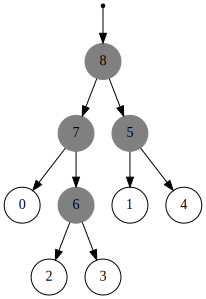

In [14]:
ct = CellTree(5)
ct.to_graphviz()

In [15]:
for node in ct.root.reverse_DFS: 
    print(node.ID)

1
4
5
0
2
3
6
7
8


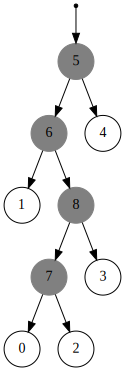

In [14]:
ct.subtree_swap(ct.nodes[1], ct.nodes[4])
ct.to_graphviz()

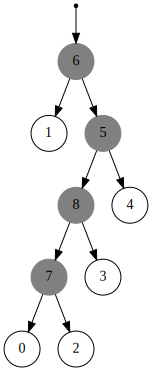

In [15]:
ct.prune_insert(ct.nodes[4], ct.nodes[8])
ct.to_graphviz()

In [4]:
def infer_tree(likelihoods1, likelihoods2): 
    n_cells, n_mut = likelihoods1.shape
    current_tree = CellTree(n_cells, n_mut)
    proposed_tree = CellTree().copy(current_tree)

In [10]:
mt = MutationTree(8)

mt.nodes[1].assign_parent(self.nodes[0])
mt.nodes[2].assign_parent(self.nodes[0])
mt.nodes[3].assign_parent(self.nodes[0])
mt.nodes[4].assign_parent(self.nodes[1])
mt.nodes[5].assign_parent(self.nodes[2])
mt.nodes[6].assign_parent(self.nodes[2])

mt.nodes[1].mutations = [0,1]
mt.nodes[2].mutations = [2]
mt.nodes[3].mutations = [3]
mt.nodes[4].mutations = [4]
mt.nodes[5].mutations = [5]
mt.nodes[6].mutations = [6]

mt.attachments = np.array([1,1,0,5,5,5,3,2], dtype = int)

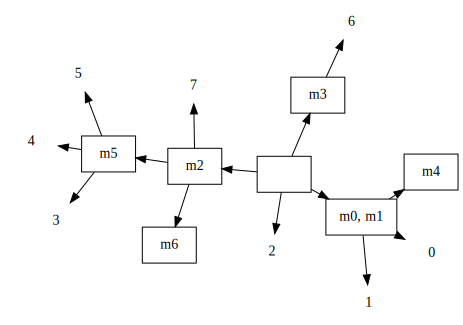

In [11]:
mt.to_graphviz()

### SVD Imputation

In [ ]:
# X: data matrix in which rows (dimension 0) are samples and columns (dimension 1) are features
def mean_impute(X): 
    X_imputed = X.copy() 
    for i in range(X.shape[1]): 
        feature = X[:,i] 
        mean = np.nanmean(feature) # take mean of the feature, ignoring NaN
        if np.isnan(mean): 
            print('[Mean Imputation] WARNING: Empty feature at column %d.'%i) 
        nan_indices = np.where(np.isnan(feature))[0] 
        X_imputed[nan_indices,i] = mean 
    return X_imputed 


def zero_impute(X): 
    X_imputed = X.copy()
    X_imputed[np.isnan(X)] = 0
    return X_imputed
    

def svd_impute(X, rank = None, tol = 0.1, max_iter = 100):
    if rank is None: 
        rank = min(X.shape) // 2
    
    nan_indices = np.where(np.isnan(X))
    X_imputed = zero_impute(X) #initialise all nan entries with the a mean imputation
    
    for i in tqdm(range(max_iter)):
        X_old = X_imputed.copy()
        L,D,R = np.linalg.svd(X_imputed)
        X_approx = L[:,:rank] @ np.diag(D[:rank]) @ R[:rank,:] #rank r approximation of X_imputed
        X_imputed[nan_indices] = X_approx[nan_indices]
        fnorm = np.linalg.norm(X_old - X_imputed, ord="fro")
        if fnorm < tol:
            print('[SVD Imputation]: Converged after %d iterations.'%(i+1))
            print('Frobenius norm:', fnorm)
            break
        if (i+1) >= max_iter:
            print('[SVD Imputation]: Maximum number (%d) of iterations reached.'%(i+1))
            print('Frobenius norm:', fnorm)
    
    return X_imputed

In [ ]:
ref.shape

In [ ]:
np.sum(alt > 5, axis = 1)

In [ ]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = (16, 12))
    plt.plot(np.sum(alt > 16, axis = 1))
    plt.show()

In [ ]:
for i in range(ref.shape[0]): 
    for j in range(ref.shape[1]): 
        if ref[i,j] == 0 and alt[i,j] == 0:
            ref[i,j] = np.nan
            alt[i,j] = np.nan

In [ ]:
X = np.concatenate([ref, alt], axis = 1)
X_imputed = svd_impute(X, rank = 5)

In [ ]:
X_imputed.shape

In [ ]:
ref_imputed = X_imputed[:,:ref.shape[1]]
alt_imputed = X_imputed[:,ref.shape[1]:]

In [ ]:
ref_proportion = (ref_imputed + 1) / (ref_imputed + alt_imputed + 2)

plt.figure(figsize=(24,16))
plt.imshow(ref_proportion.T, cmap = 'viridis', vmin = 0., vmax = 1.) 
# "viridis": yellow for 1, purple for 0, green/blue for 0.5 (https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html)
plt.xlabel('locus index', fontsize = 17)
plt.ylabel('cell index', fontsize = 17)
plt.show()

### HMM

In [ ]:
# I: initial probability
# T: transition probability (including the begin state)
# E: emission probability
# X: observation
def viterbi(I, T, E, X):
    length = X.shape[0]
    n_states = X.shape[1]
    v = np.zeros((length, n_states)) # v[j, k] = max joint probability having k at step j and emission X[i]
    
    v[0,:] = np.array([I[i] * E(i, X[0]) for i in range(n_states)])
    for j in range(1, length):
        for k in range(n_states):
            v[j,k] = E(k, X[j]) * np.max([v[j-1,l] * T(l,k) for l in range(n_states)]) # l: assumed state of previous step
    
    best_path = np.argmax(v, axis = 1)
    
    return best_path, v[-1, best_path[-1]] # second return is the max joint probability

In [ ]:
transition_matrix = np.array([[0.9, 0.1],
                              [0.5, 0.5]])
def T(pre, post):
    return transition_matrix[pre, post]

In [ ]:
def E(state, obs, f = 0.7, omega = 10):
    n_ref = obs[0]
    coverage = np.sum(obs)
    if state == 1: # normal (heterozygous)
        alpha = (1/2 - 2/3 * f) / omega
        beta = omega - alpha
    elif state == 2: # LOH
        alpha = f * omega
        beta = omega - alpha
    else: 
        print('\n ERROR: invalid state \n')
        return
    
    return betabinom.pmf(n_ref, coverage, alpha, beta)

In [ ]:
X = np.stack((np.array(df_ref.loc['chr1',:])[0,:], np.array(df_alt.loc['chr1',:])[0,:])).T
X